<a href="https://colab.research.google.com/github/Gokul7904231/Sentiment_Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
uploaded = files.upload()


Saving test(in).csv to test(in) (1).csv


In [10]:
!pip install transformers
!pip install torch
!pip install seaborn


In [11]:
import pandas as pd

# Load CSV
df = pd.read_csv('test(in).csv')  # or use file_path if from Drive

# Rename columns for consistency
df = df.rename(columns={
    'Subject': 'subject',
    'body': 'message',
    'date': 'timestamp',
    'from': 'employee_id'
})

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Check data
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   subject      2191 non-null   object        
 1   message      2191 non-null   object        
 2   timestamp    2191 non-null   datetime64[ns]
 3   employee_id  2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 68.6+ KB


,subject,message,timestamp,employee_id
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [12]:
from transformers import pipeline

# Load pre-trained sentiment analysis model
classifier = pipeline('sentiment-analysis')

# Apply to messages (limit to 512 tokens per message)
df['Sentiment'] = df['message'].apply(lambda x: classifier(x[:512])[0]['label'])

# Map to readable format
df['Sentiment'] = df['Sentiment'].map({'POSITIVE': 'Positive', 'NEGATIVE': 'Negative'})

# Check result
df['Sentiment'].value_counts()


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


,count
Sentiment,
Negative,1204
Positive,987


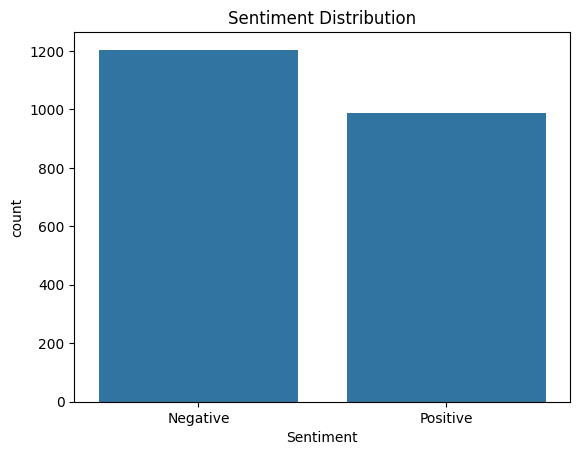

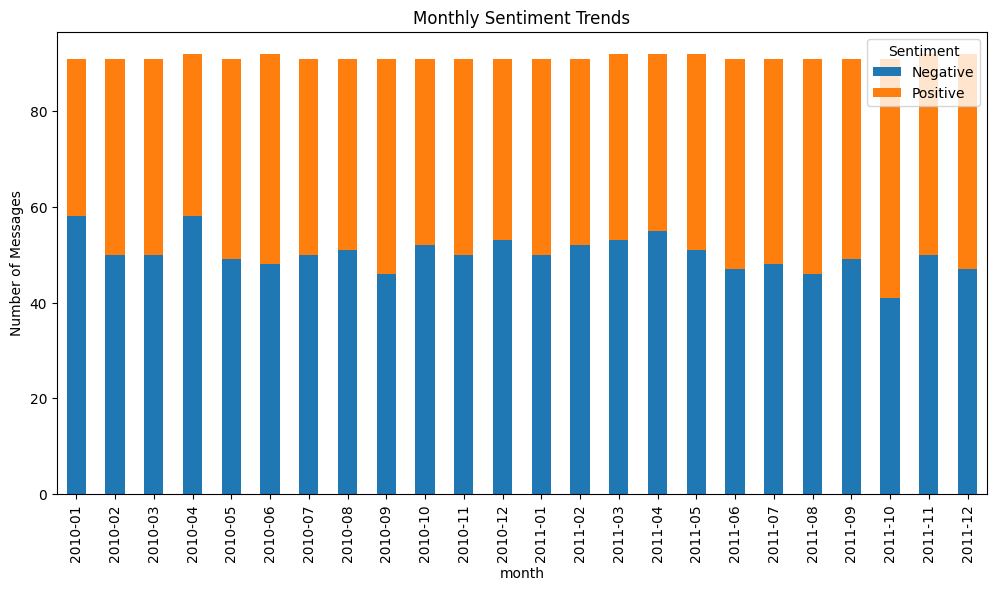

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment Distribution
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

# Create month column
df['month'] = df['timestamp'].dt.to_period('M')

# Monthly trend of sentiments
monthly_sentiment = df.groupby(['month', 'Sentiment']).size().unstack().fillna(0)
monthly_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Monthly Sentiment Trends')
plt.ylabel('Number of Messages')
plt.show()


In [14]:
# Assign scores
def get_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

df['score'] = df['Sentiment'].apply(get_score)
df['month'] = df['timestamp'].dt.to_period('M')

# Monthly score by employee
monthly_scores = df.groupby(['employee_id', 'month'])['score'].sum().reset_index()
monthly_scores.head()


,employee_id,month,score
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-2
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
def get_top_employees(month):
    data = monthly_scores[monthly_scores['month'] == month]
    top_positive = data.sort_values(by='score', ascending=False).head(3)
    top_negative = data.sort_values(by='score').head(3)
    return top_positive, top_negative

# Example for one month
top_pos, top_neg = get_top_employees('2023-01')
print("Top Positive Employees:\n", top_pos)
print("Top Negative Employees:\n", top_neg)


Top Positive Employees:
 Empty DataFrame
Columns: [employee_id, month, score]
Index: []
Top Negative Employees:
 Empty DataFrame
Columns: [employee_id, month, score]
Index: []


In [16]:
df['is_negative'] = df['Sentiment'] == 'Negative'
df['date'] = df['timestamp'].dt.date

flight_risks = []

for emp in df['employee_id'].unique():
    emp_data = df[df['employee_id'] == emp].sort_values('timestamp')
    emp_data = emp_data.set_index('timestamp').resample('1D')['is_negative'].sum().fillna(0)
    emp_data = emp_data.rolling(window=30).sum()
    if (emp_data >= 4).any():
        flight_risks.append(emp)

print("Flight Risk Employees:", flight_risks)


Flight Risk Employees: ['sally.beck@enron.com', 'eric.bass@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'kayne.coulter@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'don.baughman@enron.com', 'john.arnold@enron.com', 'bobette.riner@ipgdirect.com']


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Create additional features
df['message_length'] = df['message'].apply(len)
df['word_count'] = df['message'].apply(lambda x: len(x.split()))

# Monthly features
monthly_features = df.groupby(['employee_id', 'month']).agg({
    'score': 'sum',
    'message': 'count',
    'message_length': 'mean',
    'word_count': 'mean'
}).rename(columns={'message': 'msg_count'}).reset_index()

# Prepare training data
X = monthly_features[['msg_count', 'message_length', 'word_count']]
y = monthly_features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))


R2 Score: 0.008817954676799133


In [18]:

df.to_csv('sentiment_labeled.csv', index=False)

from google.colab import files
files.download('sentiment_labeled.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>